# L&T Financial Services Data Science FinHack ( ML Hackathon)

### Link: https://datahack.analyticsvidhya.com/contest/ltfs-datascience-finhack-an-online-hackathon/

# Problem Statement

#### Vehicle Loan Default Prediction

Financial institutions incur significant losses due to the default of vehicle loans. This has led to the tightening up of vehicle loan underwriting and increased vehicle loan rejection rates. The need for a better credit risk scoring model is also raised by these institutions. This warrants a study to estimate the determinants of vehicle loan default.
A financial institution has hired you to accurately predict the probability of loanee/borrower defaulting on a vehicle loan in the first EMI (Equated Monthly Instalments) on the due date. Following Information regarding the loan and loanee are provided in the datasets:

#### Loanee Information (Demographic data like age, Identity proof etc.)

#### Loan Information (Disbursal details, loan to value ratio etc.)

#### Bureau data & history (Bureau score, number of active accounts, the status of other loans, credit history etc.)

Doing so will ensure that clients capable of repayment are not rejected and important determinants can be identified which can be further used for minimising the default rates.

## Data Description

#### train.zip

train.zip contains train.csv and data_dictionary.csv.

train.csv contains the training data with details on loan as described in the last section

#### data_dictionary.

csv contains a brief description on each variable provided in the training and test set.

#### test.csv

test.csv contains details of all customers and loans for which the participants are to submit probability of default.
 

## Evaluation Metric
#### Submissions are evaluated on area under the ROC curve between the predicted probability and the observed target.


In [553]:
# importing libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import datetime
import warnings
import joblib
from tqdm import tqdm
from dateutil.parser import parse
import matplotlib.patches as patches
import matplotlib.path as path
import matplotlib.animation as animation
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
import seaborn as sns
import scikitplot as skplt
warnings.filterwarnings("ignore")

In [181]:
#reading data
train_df = pd.read_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/train.csv")

In [182]:
#Overview of Data
train_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,Self employed,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,Self employed,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1


# 1. Exploratory Data Analysis

In [561]:
# Pre-defined functions

# resetting index
def reset_index(data_frame):
    data_frame = data_frame.reset_index()
    data_frame['index_col'] = data_frame.index

    data_frame = data_frame.drop("index", axis=1)
    data_frame = data_frame.drop("index_col", axis=1)
    return(data_frame)


# checking for NaN values
def NaN_values(data_frame):
    bool_series = pd.isnull(data_frame) 
  
    # displayind data only with team = NaN 
    print("Number of rows with NaN values = ",len(data_frame[bool_series]))
    return (data_frame[bool_series][:10])


# count of number of instances of each column (unique values)
def unique_value(data_frame):
    unique_values = data_frame.value_counts()
    print('Number of unique_values :', unique_values.shape[0])

    # the top 10 branches that occured most
    print(unique_values.head(10))
    

# function to convert date_of_birth to age
def age(data_frame):
    dt = parse(data_frame)       
    now = datetime.datetime.today()  
    age = now.year - dt.year
    return(age)


# changing years to months
def total_months(data_frame):
    yrs, mon = data_frame.split() 
    remove_yrs = yrs.replace("yrs", "")
    remove_mon = mon.replace("mon", "")
    int_yrs = int(remove_yrs)
    int_mon = int(remove_mon)
    total_mon = (12*int_yrs)+(int_mon)
    return(total_mon)


def plot_confusion_matrix(actual,predicted):
    cm = confusion_matrix(actual, predicted)
    class_label = ["negative", "positive"]
    df_cm = pd.DataFrame(cm, index = class_label, columns = class_label)
    sns.heatmap(df_cm, annot = True, fmt = "d")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    

def plot_ROC_curve(actual, predicted_proba):
    skplt.metrics.plot_roc_curve(actual,predicted_proba)

### 1.1 Checking data of disbursed_amount

In [191]:
#Checking for NaN values 
NaN_val = NaN_values(train_df['disbursed_amount'])

# checking for unique values
val = unique_value(train_df['disbursed_amount'])

Number of rows with NaN values =  0
Number of unique_values : 24565
48349    2140
53303    2125
51303    1992
50303    1960
55259    1887
52303    1868
47349    1853
56259    1637
46349    1605
57259    1601
Name: disbursed_amount, dtype: int64


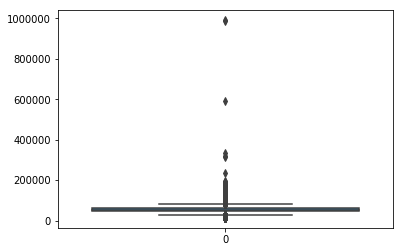

In [195]:
#plotting boxplot of disbursed_amount
disbursed_amount = train_df['disbursed_amount']
sns.boxplot(data =disbursed_amount)
plt.show()

In [187]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var =disbursed_amount
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 13320
10 percentile value is 39794
20 percentile value is 45343
30 percentile value is 48599
40 percentile value is 51303
50 percentile value is 53803
60 percentile value is 56196
70 percentile value is 58759
80 percentile value is 62447
90 percentile value is 68882
100 percentile value is  990572


In [188]:
#looking further from the 99th percecntile
for i in range(90,100):
    var = disbursed_amount
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 68882
91 percentile value is 69923
92 percentile value is 71023
93 percentile value is 72023
94 percentile value is 72817
95 percentile value is 74123
96 percentile value is 77079
97 percentile value is 80686
98 percentile value is 85770
99 percentile value is 95391
100 percentile value is  990572


In [189]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = disbursed_amount
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 95391
99.1 percentile value is 95699
99.2 percentile value is 95899
99.3 percentile value is 96490
99.4 percentile value is 97290
99.5 percentile value is 97799
99.6 percentile value is 98480
99.7 percentile value is 107407
99.8 percentile value is 115418
99.9 percentile value is 123196
100 percentile value is  990572


In [190]:
#removing further outliers based on the 99.6th percentile value
train_df_new = train_df[(train_df.disbursed_amount>0) & (train_df.disbursed_amount<98480)]

print(np.shape(train_df))
print(np.shape(train_df_new))

(233154, 41)
(232218, 41)


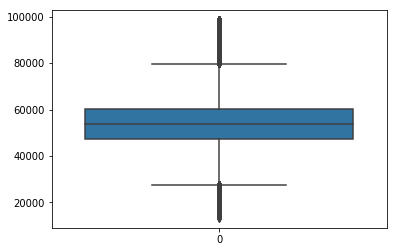

In [196]:
#plotting boxplot of disbursed_amount
disbursed_amount = train_df_new['disbursed_amount']
sns.boxplot(data =disbursed_amount)
plt.show()

### 1.2 Checking data for asset_cost

In [192]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new['asset_cost'])

# checking for unique values
val = unique_value(train_df_new['asset_cost'])

Number of rows with NaN values =  0
Number of unique_values : 45802
68000    681
67000    596
72000    539
70000    505
74000    469
66000    466
73000    462
75000    460
69000    436
65000    397
Name: asset_cost, dtype: int64


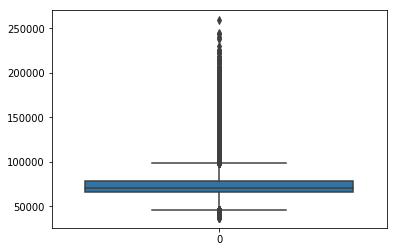

In [197]:
#plotting boxplot of asset_cost
asset_cost = train_df_new['asset_cost']
sns.boxplot(data =asset_cost)
plt.show()

In [198]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = asset_cost
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 37000
10 percentile value is 61314
20 percentile value is 64493
30 percentile value is 66721
40 percentile value is 68723
50 percentile value is 70895
60 percentile value is 73476
70 percentile value is 76711
80 percentile value is 82822
90 percentile value is 98567
100 percentile value is  259000


In [199]:
#looking further from the 99th percecntile
for i in range(90,100):
    var = asset_cost
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

90 percentile value is 98567
91 percentile value is 100130
92 percentile value is 102000
93 percentile value is 104000
94 percentile value is 106063
95 percentile value is 108549
96 percentile value is 111691
97 percentile value is 116340
98 percentile value is 124393
99 percentile value is 145652
100 percentile value is  259000


In [200]:
#calculating speed values at each percntile 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
for i in np.arange(0.0, 1.0, 0.1):
    var = asset_cost
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 145652
99.1 percentile value is 148520
99.2 percentile value is 151684
99.3 percentile value is 154650
99.4 percentile value is 158000
99.5 percentile value is 161031
99.6 percentile value is 163675
99.7 percentile value is 166800
99.8 percentile value is 172309
99.9 percentile value is 175816
100 percentile value is  259000


In [201]:
#removing further outliers based on the 95th percentile value
train_df_new_2 = train_df_new[(train_df_new.asset_cost>0) & (train_df_new.asset_cost<108549)]

print(np.shape(train_df_new))
print(np.shape(train_df_new_2))

(232218, 41)
(220607, 41)


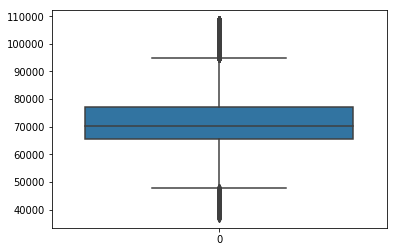

In [202]:
#plotting boxplot of asset_cost
asset_cost = train_df_new_2['asset_cost']
sns.boxplot(data =asset_cost)
plt.show()

### 1.3 Checking data for ltv 

In [204]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_2['ltv'])

# checking for unique values
val = unique_value(train_df_new_2['ltv'])

Number of rows with NaN values =  0
Number of unique_values : 6451
85.00    4430
84.99    1028
79.99     540
80.00     483
79.90     404
75.00     396
79.79     393
74.93     361
90.00     336
89.86     332
Name: ltv, dtype: int64


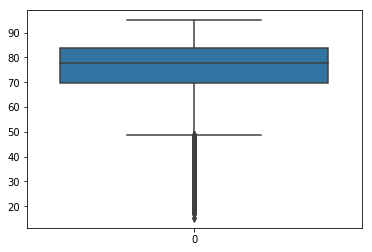

In [206]:
#plotting boxplot of ltv
ltv = train_df_new_2['ltv']
sns.boxplot(data =ltv)
plt.show()

In [25]:
#calculating 0-100th percentile to find a the correct percentile value for removal of outliers
for i in range(0,100,10):
    var = ltv
    var = np.sort(var,axis = None)
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is ",var[-1])

0 percentile value is 15.3
10 percentile value is 59.89
20 percentile value is 67.42
30 percentile value is 71.97
40 percentile value is 74.7
50 percentile value is 77.62
60 percentile value is 79.76
70 percentile value is 82.57
80 percentile value is 84.88
90 percentile value is 88.14
100 percentile value is  95.0


#### Observation: Everything seems to be fine with "ltv" column's data 

### 1.4 Checking data for branch_id 

In [207]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_2['branch_id'])

# checking for unique values
val = unique_value(train_df_new_2['branch_id'])

Number of rows with NaN values =  0
Number of unique_values : 82
2      12512
67     11197
3       9124
5       9050
36      8037
34      7529
136     7225
16      6389
19      5709
146     5285
Name: branch_id, dtype: int64


### 1.5 Checking data for  supplier_id

In [208]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_2['supplier_id'])

# checking for unique values
val = unique_value(train_df_new_2['supplier_id'])

Number of rows with NaN values =  0
Number of unique_values : 2797
18317    1429
15694    1297
15663    1272
17980    1259
14234    1255
18166    1209
21980    1123
14375    1102
22727    1062
14145    1058
Name: supplier_id, dtype: int64


### 1.6 Checking data for manufacturer_id 

In [209]:
#Checking for NaN values                                       # Need to think about this # Drop this
NaN_val = NaN_values(train_df_new_2['manufacturer_id'])

# checking for unique values
val = unique_value(train_df_new_2['manufacturer_id'])

Number of rows with NaN values =  0
Number of unique_values : 7
86     108642
45      56466
51      24966
48      12972
120      8857
49       8061
145       643
Name: manufacturer_id, dtype: int64


### 1.7 Checking data for  Current_pincode_ID

In [211]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_2['Current_pincode_ID'])

# checking for unique values
val = unique_value(train_df_new_2['Current_pincode_ID'])

Number of rows with NaN values =  0
Number of unique_values : 6617
2578    1820
1446    1700
1515    1079
2989     918
2943     887
1509     856
2782     813
1794     782
571      772
3363     712
Name: Current_pincode_ID, dtype: int64


### 1.8a Checking data for Date.of.Birth

In [212]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_2['Date.of.Birth'])

# checking for unique values
val = unique_value(train_df_new_2['Date.of.Birth'])

Number of rows with NaN values =  0
Number of unique_values : 15362
01-01-88    2063
01-01-90    2024
01-01-87    2024
01-01-86    1993
01-01-85    1934
01-01-91    1865
01-01-89    1852
01-01-92    1801
01-01-93    1780
01-01-83    1779
Name: Date.of.Birth, dtype: int64


### 1.9 Checking data for Employment.Type

In [214]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_2['Employment.Type'])

# checking for unique values
val = unique_value(train_df_new_2['Employment.Type'])

Number of rows with NaN values =  6760
Number of unique_values : 2
Self employed    120109
Salaried          93738
Name: Employment.Type, dtype: int64


In [67]:
#resetting index
train_df_new_2 = reset_index(train_df_new_2)
train_df_new_2[340:349]    #because we were getting key index 348

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
340,422687,47349,59115,82.89,130,15118,45,1043,18-02-82,Self employed,...,0,0,4060,0,0,0,2yrs 1mon,3yrs 3mon,0,0
341,457129,45645,64840,73.26,130,20700,48,984,02-09-83,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
342,651640,57509,66636,88.54,130,22637,86,1042,01-03-89,Salaried,...,0,0,1156,0,0,0,0yrs 7mon,0yrs 7mon,0,1
343,565551,48798,64987,77.71,130,20520,45,992,01-06-71,Self employed,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
344,609317,60697,69498,89.93,130,22637,86,1043,01-06-88,Self employed,...,0,0,0,0,0,0,5yrs 6mon,5yrs 6mon,0,1
345,428884,51803,62188,86.03,130,15196,86,1045,13-03-87,Salaried,...,0,0,7988,0,1,0,3yrs 1mon,9yrs 2mon,0,0
346,631505,50053,63780,80.75,130,23837,51,1063,01-03-77,Self employed,...,0,0,4814,0,3,0,0yrs 11mon,3yrs 3mon,0,0
347,467365,53854,62188,89.89,130,15218,86,1051,23-06-91,Self employed,...,0,0,3072,0,1,0,0yrs 5mon,0yrs 7mon,1,0
348,649725,58447,69804,86.67,130,20520,45,975,03-10-74,Salaried,...,0,0,5031,0,0,0,1yrs 6mon,2yrs 1mon,0,0


In [68]:
train_df_new_2[80:89]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
80,596844,47773,63306,80.56,78,17014,45,2074,01-01-70,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
81,431923,44779,62852,74.78,78,17014,45,2077,01-06-70,Salaried,...,0,0,11759,0,1,1,0yrs 8mon,0yrs 11mon,1,0
82,576883,45814,66115,71.09,78,17014,45,2069,20-03-93,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
83,434752,48468,60410,84.42,78,17014,45,2101,01-01-78,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
84,521436,44819,66487,69.19,78,17014,45,2099,01-06-69,Salaried,...,0,0,0,0,0,0,1yrs 6mon,3yrs 8mon,0,0
85,508182,50673,63840,83.02,78,17014,45,2098,01-01-97,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
86,463163,37939,64500,62.02,78,17014,45,2103,01-01-78,Salaried,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
87,525234,52428,67405,81.60,78,17014,45,2099,05-08-98,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
88,637252,51653,63896,86.08,78,17014,45,2079,24-02-99,NaN,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [69]:
# Deleting rows with NaN values
#from tqdm import *
start = dt.datetime.now()
print("Start Time =",start)

train_df_new_2['index_col'] = train_df_new_2.index
train_df_new_3 = train_df_new_2

for loop3 in range(0,len(train_df_new_2)):
    x = train_df_new_2["Employment.Type"][loop3]
    if(x == 'Salaried' or x == 'Self employed' ):
        pass 
    else:
        column_id = train_df_new_2['index_col'][loop3]
        train_df_new_3 = train_df_new_3.drop([column_id], axis=0)
        
print("\nNumber of rows & columns after deleting NaN values= ",(np.shape(train_df_new_3)))

#resetting index
train_df_new_3 = reset_index(train_df_new_3)

# replacing 'Salaried' with '1' and 'Self employed' with '0'
for loop4 in range(0,len(train_df_new_3)):
    x = train_df_new_3["Employment.Type"][loop4]
    if(x == 'Salaried'):
        train_df_new_3["Employment.Type"][loop4] = '1'
    else:
        train_df_new_3["Employment.Type"][loop4] = '0' 
        
print("Time taken to run this cell :", datetime.now() - start)

Start Time = 2019-04-13 20:49:54.605663

Number of rows & columns after deleting NaN values=  (213847, 42)


NameError: name 'datetime' is not defined

In [216]:
print(np.shape(train_df_new_2))
print(np.shape(train_df_new_3))
train_df_new_3[80:90]

(220607, 41)
(213847, 41)


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
80,596844,47773,63306,80.56,78,17014,45,2074,01-01-70,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
81,431923,44779,62852,74.78,78,17014,45,2077,01-06-70,1,...,0,0,11759,0,1,1,0yrs 8mon,0yrs 11mon,1,0
82,576883,45814,66115,71.09,78,17014,45,2069,20-03-93,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
83,434752,48468,60410,84.42,78,17014,45,2101,01-01-78,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
84,521436,44819,66487,69.19,78,17014,45,2099,01-06-69,1,...,0,0,0,0,0,0,1yrs 6mon,3yrs 8mon,0,0
85,508182,50673,63840,83.02,78,17014,45,2098,01-01-97,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
86,463163,37939,64500,62.02,78,17014,45,2103,01-01-78,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,1
87,594321,52818,63896,88.42,78,17014,45,2071,01-01-83,1,...,0,0,0,0,0,1,0yrs 0mon,0yrs 0mon,0,1
88,639321,51428,64840,84.82,78,17014,45,2095,12-07-94,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,4,0
89,573647,51663,68000,79.41,78,17014,45,2103,01-01-79,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0


In [217]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_3['Employment.Type'])

Number of rows with NaN values =  0


In [72]:
train_df_new_3[:10]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,0,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,1,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-91,0,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-68,1,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


In [81]:
import joblib                                       #  * DO NOT RUN *
joblib.dump(train_df_new_3,"train_df_new_3.pkl")

['train_df_new_3.pkl']

In [392]:
#Loading the saved data frame
train_df_new_3 = joblib.load("train_df_new_3.pkl")

In [122]:
#viewing columns further
train_df_new_3.ix[:,'Employment.Type':][:10]

,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,1,03-08-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,0,26-09-18,6,1998,1,1,0,0,0,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,0,01-08-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,0,26-10-18,6,1998,1,1,0,0,0,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,0,26-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,0,19-09-18,6,1998,1,1,0,0,0,0,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,1,23-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,1,16-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,0,05-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,1,16-09-18,6,1998,1,0,0,1,0,0,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


### 1.10 Checking values for DisbursalDate

In [218]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_3['DisbursalDate'])

# checking for unique values
val = unique_value(train_df_new_3['DisbursalDate'])

Number of rows with NaN values =  0
Number of unique_values : 84
31-10-18    8023
31-08-18    6229
24-10-18    6050
23-10-18    5767
26-10-18    5608
22-10-18    5415
25-10-18    5415
30-10-18    5262
30-08-18    4352
29-10-18    3928
Name: DisbursalDate, dtype: int64


### 1.11 Checking values for State_ID 

In [219]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_3['State_ID'])

# checking for unique values
val = unique_value(train_df_new_3['State_ID'])

Number of rows with NaN values =  0
Number of unique_values : 22
4     42538
6     32406
3     28066
13    16085
9     15188
8     12561
5      9456
1      8795
14     8065
11     6500
Name: State_ID, dtype: int64


### 1.12 Checking values of Employee_code_ID 

In [223]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['Employee_code_ID'])

# checking for unique values
val = unique_value(train_df_new_3['Employee_code_ID'])

Number of rows with NaN values =  0
Number of unique_values : 3257
2546    627
255     454
620     453
2153    401
130     399
1466    345
64      335
751     334
2058    334
1494    327
Name: Employee_code_ID, dtype: int64


### 1.13 Checking values for MobileNo_Avl_Flag 

In [224]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['MobileNo_Avl_Flag'])

# checking for unique values
val = unique_value(train_df_new_3['MobileNo_Avl_Flag'])

Number of rows with NaN values =  0
Number of unique_values : 1
1    213847
Name: MobileNo_Avl_Flag, dtype: int64


### 1.14 Checking values for Aadhar_flag 

In [225]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['Aadhar_flag'])

# checking for unique values
val = unique_value(train_df_new_3['Aadhar_flag'])

Number of rows with NaN values =  0
Number of unique_values : 2
1    180099
0     33748
Name: Aadhar_flag, dtype: int64


### 1.15 Checking values for PAN_flag 

In [226]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PAN_flag'])

# checking for unique values
val = unique_value(train_df_new_3['PAN_flag'])

Number of rows with NaN values =  0
Number of unique_values : 2
0    197824
1     16023
Name: PAN_flag, dtype: int64


### 1.16 Checking values for VoterID_flag 

In [227]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['VoterID_flag'])

# checking for unique values
val = unique_value(train_df_new_3['VoterID_flag'])

Number of rows with NaN values =  0
Number of unique_values : 2
0    183201
1     30646
Name: VoterID_flag, dtype: int64


### 1.17 Checking values for Driving_flag 

In [228]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['Driving_flag'])

# checking for unique values
val = unique_value(train_df_new_3['Driving_flag'])

Number of rows with NaN values =  0
Number of unique_values : 2
0    208907
1      4940
Name: Driving_flag, dtype: int64


### 1.18 Checking values for Passport_flag 

In [229]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['Passport_flag'])

# checking for unique values
val = unique_value(train_df_new_3['Passport_flag'])

Number of rows with NaN values =  0
Number of unique_values : 2
0    213394
1       453
Name: Passport_flag, dtype: int64


In [230]:
#viewing columns further
train_df_new_3.ix[:,'Passport_flag':][:10]

,Passport_flag,PERFORM_CNS.SCORE,PERFORM_CNS.SCORE.DESCRIPTION,PRI.NO.OF.ACCTS,PRI.ACTIVE.ACCTS,PRI.OVERDUE.ACCTS,PRI.CURRENT.BALANCE,PRI.SANCTIONED.AMOUNT,PRI.DISBURSED.AMOUNT,SEC.NO.OF.ACCTS,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,0,0,No Bureau History Available,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,0,598,I-Medium Risk,1,1,1,27600,50200,50200,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,0,0,No Bureau History Available,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,0,305,L-Very High Risk,3,0,0,0,0,0,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,0,0,No Bureau History Available,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,0,825,A-Very Low Risk,2,0,0,0,0,0,0,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,0,0,No Bureau History Available,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,0,17,Not Scored: Not Enough Info available on the c...,1,1,0,72879,74500,74500,0,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,0,718,D-Very Low Risk,1,1,0,-41,365384,365384,0,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,0,818,A-Very Low Risk,1,0,0,0,0,0,0,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


### 1.19 Checking values for PERFORM_CNS.SCORE 

In [231]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PERFORM_CNS.SCORE'])

# checking for unique values
val = unique_value(train_df_new_3['PERFORM_CNS.SCORE'])

Number of rows with NaN values =  0
Number of unique_values : 572
0      105531
300      8247
738      8152
825      6988
15       3484
17       3370
763      2871
16       2673
708      1994
737      1811
Name: PERFORM_CNS.SCORE, dtype: int64


### 1.20 Checking values for PERFORM_CNS.SCORE.DESCRIPTION 

In [232]:
#Checking for NaN values                                              
NaN_val = NaN_values(train_df_new_3['PERFORM_CNS.SCORE.DESCRIPTION'])

# checking for unique values
val = unique_value(train_df_new_3['PERFORM_CNS.SCORE.DESCRIPTION'])

Number of rows with NaN values =  0
Number of unique_values : 20
No Bureau History Available    105531
C-Very Low Risk                 14996
A-Very Low Risk                 13230
D-Very Low Risk                 10612
B-Very Low Risk                  8639
M-Very High Risk                 8247
F-Low Risk                       7881
K-High Risk                      7683
H-Medium Risk                    6371
E-Low Risk                       5412
Name: PERFORM_CNS.SCORE.DESCRIPTION, dtype: int64


### 1.21 Checking values for PRI.NO.OF.ACCTS 

In [233]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRI.NO.OF.ACCTS'])

# checking for unique values
val = unique_value(train_df_new_3['PRI.NO.OF.ACCTS'])

Number of rows with NaN values =  0
Number of unique_values : 106
0    105531
1     32427
2     18438
3     12163
4      8742
5      6768
6      5239
7      4142
8      3322
9      2670
Name: PRI.NO.OF.ACCTS, dtype: int64


### 1.22 Checking values for PRI.ACTIVE.ACCTS 

In [234]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRI.ACTIVE.ACCTS'])

# checking for unique values
val = unique_value(train_df_new_3['PRI.ACTIVE.ACCTS'])

Number of rows with NaN values =  0
Number of unique_values : 40
0    124366
1     39014
2     20100
3     11433
4      6978
5      4226
6      2613
7      1681
8      1115
9       695
Name: PRI.ACTIVE.ACCTS, dtype: int64


### 1.23 Checking values of PRI.OVERDUE.ACCTS 

In [235]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRI.OVERDUE.ACCTS'])

# checking for unique values
val = unique_value(train_df_new_3['PRI.OVERDUE.ACCTS'])

Number of rows with NaN values =  0
Number of unique_values : 22
0    189307
1     18619
2      4030
3      1127
4       384
5       160
6        91
7        38
8        26
9        22
Name: PRI.OVERDUE.ACCTS, dtype: int64


### 1.24 Checking values for PRI.CURRENT.BALANCE 

In [236]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRI.CURRENT.BALANCE'])

# checking for unique values
val = unique_value(train_df_new_3['PRI.CURRENT.BALANCE'])

Number of rows with NaN values =  0
Number of unique_values : 66976
0         128755
800          118
400          115
30000         96
50000         79
100000        76
40000         71
25000         69
20000         61
60000         60
Name: PRI.CURRENT.BALANCE, dtype: int64


### 1.25 Checking values for PRI.SANCTIONED.AMOUNT 

In [237]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRI.SANCTIONED.AMOUNT'])

# checking for unique values
val = unique_value(train_df_new_3['PRI.SANCTIONED.AMOUNT'])

Number of rows with NaN values =  0
Number of unique_values : 41844
0         125363
50000       1404
30000       1365
100000       903
25000        886
40000        808
20000        799
200000       561
60000        557
15000        523
Name: PRI.SANCTIONED.AMOUNT, dtype: int64


### 1.26 Checking values for PRI.DISBURSED.AMOUNT 

In [238]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRI.DISBURSED.AMOUNT'])

# checking for unique values
val = unique_value(train_df_new_3['PRI.DISBURSED.AMOUNT'])

Number of rows with NaN values =  0
Number of unique_values : 45077
0         125459
50000       1305
30000       1268
100000       879
40000        734
25000        705
20000        626
200000       568
300000       507
60000        494
Name: PRI.DISBURSED.AMOUNT, dtype: int64


### 1.27 Checking values for SEC.NO.OF.ACCTS 

In [239]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.NO.OF.ACCTS'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.NO.OF.ACCTS'])

Number of rows with NaN values =  0
Number of unique_values : 37
0    208299
1      3261
2       980
3       422
4       279
5       145
6       111
7        75
8        65
9        36
Name: SEC.NO.OF.ACCTS, dtype: int64


In [240]:
#viewing columns further
train_df_new_3.ix[:,'SEC.NO.OF.ACCTS':][:10]

,SEC.NO.OF.ACCTS,SEC.ACTIVE.ACCTS,SEC.OVERDUE.ACCTS,SEC.CURRENT.BALANCE,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,0,0,0,0,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,0,0,0,0,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,0,0,0,0,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,0,0,0,0,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,0,0,0,0,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,0,0,0,0,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,0,0,0,0,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


### 1.28 Checking values for SEC.ACTIVE.ACCTS 

In [241]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.ACTIVE.ACCTS'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.ACTIVE.ACCTS'])

Number of rows with NaN values =  0
Number of unique_values : 23
0    210239
1      2522
2       602
3       187
4       115
5        63
6        32
7        22
8        17
9        10
Name: SEC.ACTIVE.ACCTS, dtype: int64


### 1.29 Checking values for SEC.OVERDUE.ACCTS 

In [242]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.OVERDUE.ACCTS'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.OVERDUE.ACCTS'])

Number of rows with NaN values =  0
Number of unique_values : 9
0    212583
1      1061
2       122
3        46
4        19
5         8
6         6
8         1
7         1
Name: SEC.OVERDUE.ACCTS, dtype: int64


### 1.30 Checking values for SEC.CURRENT.BALANCE 

In [243]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.CURRENT.BALANCE'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.CURRENT.BALANCE'])

Number of rows with NaN values =  0
Number of unique_values : 3073
 0       210665
 800          9
 100          8
 400          8
 1200         6
-1            5
 589          4
 1070         4
 1            4
 1600         4
Name: SEC.CURRENT.BALANCE, dtype: int64


### 1.31 Checking values for SEC.SANCTIONED.AMOUNT 

In [244]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.SANCTIONED.AMOUNT'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.SANCTIONED.AMOUNT'])

Number of rows with NaN values =  0
Number of unique_values : 2120
0         210317
50000         78
100000        56
30000         42
200000        37
40000         35
15000         35
10000         30
25000         30
300000        30
Name: SEC.SANCTIONED.AMOUNT, dtype: int64


### 1.32 Checking values for SEC.DISBURSED.AMOUNT 

In [245]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.DISBURSED.AMOUNT'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.DISBURSED.AMOUNT'])

Number of rows with NaN values =  0
Number of unique_values : 2429
0         210345
50000         55
100000        43
200000        35
300000        29
40000         28
500000        25
30000         25
400000        21
150000        21
Name: SEC.DISBURSED.AMOUNT, dtype: int64


### 1.33 Checking values for PRIMARY.INSTAL.AMT 

In [246]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['PRIMARY.INSTAL.AMT'])

# checking for unique values
val = unique_value(train_df_new_3['PRIMARY.INSTAL.AMT'])

Number of rows with NaN values =  0
Number of unique_values : 26855
0       144962
1620       285
1500       145
1600       135
2000       132
2500       131
1149       124
1250       114
1700       106
1350        98
Name: PRIMARY.INSTAL.AMT, dtype: int64


### 1.34 Checking values for SEC.INSTAL.AMT 

In [247]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['SEC.INSTAL.AMT'])

# checking for unique values
val = unique_value(train_df_new_3['SEC.INSTAL.AMT'])

Number of rows with NaN values =  0
Number of unique_values : 1841
0        211732
2100          7
5000          6
1232          6
1065          6
1100          6
2400          5
1834          5
833           5
50000         5
Name: SEC.INSTAL.AMT, dtype: int64


### 1.35 Checking values for NEW.ACCTS.IN.LAST.SIX.MONTHS

In [248]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['NEW.ACCTS.IN.LAST.SIX.MONTHS'])

# checking for unique values
val = unique_value(train_df_new_3["NEW.ACCTS.IN.LAST.SIX.MONTHS"])

Number of rows with NaN values =  0
Number of unique_values : 26
0    165628
1     29924
2     10278
3      4189
4      1837
5       890
6       454
7       282
8       136
9        77
Name: NEW.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64


### 1.36 Checking values for DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS 

In [249]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'])

# checking for unique values
val = unique_value(train_df_new_3['DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS'])

Number of rows with NaN values =  0
Number of unique_values : 14
0     196911
1      13926
2       2289
3        491
4        127
5         54
6         20
7         12
8          7
11         3
Name: DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS, dtype: int64


### 1.37 Checking values for AVERAGE.ACCT.AGE 

In [250]:
#Checking for NaN values                                  # Convert years to months
NaN_val = NaN_values(train_df_new_3['AVERAGE.ACCT.AGE'])

# checking for unique values
val = unique_value(train_df_new_3['AVERAGE.ACCT.AGE'])

Number of rows with NaN values =  0
Number of unique_values : 191
0yrs 0mon     107766
0yrs 6mon       5685
0yrs 7mon       5069
0yrs 11mon      4861
0yrs 10mon      4755
1yrs 0mon       4689
0yrs 9mon       4686
0yrs 8mon       4565
1yrs 1mon       4163
0yrs 5mon       4045
Name: AVERAGE.ACCT.AGE, dtype: int64


### 1.38 Checking values for CREDIT.HISTORY.LENGTH 

In [251]:
#Checking for NaN values                                   # Convert years to months
NaN_val = NaN_values(train_df_new_3['CREDIT.HISTORY.LENGTH'])

# checking for unique values
val = unique_value(train_df_new_3['CREDIT.HISTORY.LENGTH'])

Number of rows with NaN values =  0
Number of unique_values : 290
0yrs 0mon     107539
0yrs 6mon       4510
2yrs 1mon       4386
0yrs 7mon       3793
2yrs 0mon       3533
1yrs 0mon       3171
1yrs 1mon       2843
0yrs 11mon      2430
0yrs 8mon       2291
0yrs 9mon       2248
Name: CREDIT.HISTORY.LENGTH, dtype: int64


### 1.39 Checking values for NO.OF_INQUIRIES 

In [252]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['NO.OF_INQUIRIES'])

# checking for unique values
val = unique_value(train_df_new_3['NO.OF_INQUIRIES'])

Number of rows with NaN values =  0
Number of unique_values : 25
0    184850
1     20697
2      5025
3      1649
4       718
5       314
6       228
7       129
8        96
9        41
Name: NO.OF_INQUIRIES, dtype: int64


### 1.40 Checking values for loan_default 

In [253]:
#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['loan_default'])

# checking for unique values
val = unique_value(train_df_new_3['loan_default'])

Number of rows with NaN values =  0
Number of unique_values : 2
0    167616
1     46231
Name: loan_default, dtype: int64


### 1.8b Checking again Date.of.Birth values (converting DoB to Age) 

In [255]:
#Checking for NaN values                                       
NaN_val = NaN_values(train_df_new_3['Date.of.Birth'])

# checking for unique values
val = unique_value(train_df_new_3['Date.of.Birth'])

Number of rows with NaN values =  0
Number of unique_values : 14373
01-01-88    2034
01-01-87    2005
01-01-90    1995
01-01-86    1955
01-01-85    1906
01-01-91    1835
01-01-89    1829
01-01-92    1784
01-01-83    1758
01-01-93    1754
Name: Date.of.Birth, dtype: int64


In [389]:
train_df_new_3[:11]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,01-01-84,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,31-07-85,0,...,0,0,1991,0,0,1,1yrs 11mon,1yrs 11mon,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,24-08-85,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,30-12-93,0,...,0,0,31,0,0,0,0yrs 8mon,1yrs 3mon,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,09-12-77,0,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,08-09-90,0,...,0,0,1347,0,0,0,1yrs 9mon,2yrs 0mon,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,01-06-88,1,...,0,0,0,0,0,0,0yrs 0mon,0yrs 0mon,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,04-10-89,1,...,0,0,0,0,0,0,0yrs 2mon,0yrs 2mon,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,15-11-91,0,...,0,0,0,0,0,0,4yrs 8mon,4yrs 8mon,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,01-06-68,1,...,0,0,2608,0,0,0,1yrs 7mon,1yrs 7mon,0,0


In [394]:
# converting date_of_birth to age
start = datetime.datetime.now()
print("Current Time = ",start)

for loop5 in range(0,len(train_df_new_3)):
    x = train_df_new_3['Date.of.Birth'][loop5]
    current_age = age(x)
    
    train_df_new_3['Date.of.Birth'][loop5] = current_age

current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

Current Time =  2019-04-14 13:32:10.149223
Time taken to run this cell:  8:30:54.957518


In [405]:
train_df_new_3['Date.of.Birth'][0:10]

0     35
1     34
2     34
3     26
4     42
5     29
6     31
7     30
8     28
9    -49
Name: Date.of.Birth, dtype: object

In [408]:
start = datetime.datetime.now()
print("Current Time = ",start)

'''
examples:
1964
2019-1964 = 55
2019-2064 = -45

1968
2019-1968 = 51
2019-2068 = -49

1969
2019-1969 = 50
2019-2069 = -50    # #f years above 50 = #f years below 50

1970
2019-1970 = 49
2019-2070 = -51
'''

# code to change (-ve) age to (+ve) age, as for ex: instead of 1968, it took some 19yy as 20yy
for i in range(0,len(train_df_new_3)):
    val = train_df_new_3['Date.of.Birth'][i]
    if(val < 0):
        amt_val = 50 - abs(val) 
        train_df_new_3['Date.of.Birth'][i] = 50 + amt_val
        
current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

Current Time =  2019-04-15 15:05:23.552997
Time taken to run this cell:  0:44:18.509344


In [409]:
train_df_new_3['Date.of.Birth'][0:10]

0    35
1    34
2    34
3    26
4    42
5    29
6    31
7    30
8    28
9    51
Name: Date.of.Birth, dtype: object

In [401]:
# converting values of columns "AVERAGE.ACCT.AGE" & "CREDIT.HISTORY.LENGTH" from years to month
start = datetime.datetime.now()
print("Current Time = ",start)

for loop6 in range(0,len(train_df_new_3)):
    x = train_df_new_3['AVERAGE.ACCT.AGE'][loop6]
    total_mon = total_months(x)
    train_df_new_3['AVERAGE.ACCT.AGE'][loop6] = total_mon
    
    x = train_df_new_3['CREDIT.HISTORY.LENGTH'][loop6]
    total_mon = total_months(x)
    train_df_new_3['CREDIT.HISTORY.LENGTH'][loop6] = total_mon
    
current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

Current Time =  2019-04-14 22:28:15.078349
Time taken to run this cell:  16:16:32.152047


In [403]:
train_df_new_3['AVERAGE.ACCT.AGE'][0:5]

0     0
1    23
2     0
3     8
4     0
Name: AVERAGE.ACCT.AGE, dtype: object

In [404]:
train_df_new_3['CREDIT.HISTORY.LENGTH'][0:5]

0     0
1    23
2     0
3    15
4     0
Name: CREDIT.HISTORY.LENGTH, dtype: object

In [410]:
import joblib                                       #  * DO NOT RUN *
joblib.dump(train_df_new_3,"train_df_new_3.pkl")

['train_df_new_3.pkl']

In [411]:
#Loading the saved Train data frame
train_df_new_3 = joblib.load("train_df_new_3.pkl")

In [418]:
train_df_new_3[:10]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,35,1,...,0,0,0,0,0,0,0,0,0,0
1,537409,47145,65550,73.23,67,22807,45,1502,34,0,...,0,0,1991,0,0,1,23,23,0,1
2,417566,53278,61360,89.63,67,22807,45,1497,34,0,...,0,0,0,0,0,0,0,0,0,0
3,624493,57513,66113,88.48,67,22807,45,1501,26,0,...,0,0,31,0,0,0,8,15,1,1
4,539055,52378,60300,88.39,67,22807,45,1495,42,0,...,0,0,0,0,0,0,0,0,1,1
5,518279,54513,61900,89.66,67,22807,45,1501,29,0,...,0,0,1347,0,0,0,21,24,0,0
6,529269,46349,61500,76.42,67,22807,45,1502,31,1,...,0,0,0,0,0,0,0,0,0,0
7,510278,43894,61900,71.89,67,22807,45,1501,30,1,...,0,0,0,0,0,0,2,2,0,0
8,490213,53713,61973,89.56,67,22807,45,1497,28,0,...,0,0,0,0,0,0,56,56,1,0
9,510980,52603,61300,86.95,67,22807,45,1492,51,1,...,0,0,2608,0,0,0,19,19,0,0


In [484]:
#viewing columns further
train_df_new_3.ix[:,'Employment.Type':][:10]

,Employment.Type,DisbursalDate,State_ID,Employee_code_ID,MobileNo_Avl_Flag,Aadhar_flag,PAN_flag,VoterID_flag,Driving_flag,Passport_flag,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,1,03-08-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,26-09-18,6,1998,1,1,0,0,0,0,...,0,0,1991,0,0,1,23,23,0,1
2,0,01-08-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,26-10-18,6,1998,1,1,0,0,0,0,...,0,0,31,0,0,0,8,15,1,1
4,0,26-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,1
5,0,19-09-18,6,1998,1,1,0,0,0,0,...,0,0,1347,0,0,0,21,24,0,0
6,1,23-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1,16-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,2,2,0,0
8,0,05-09-18,6,1998,1,1,0,0,0,0,...,0,0,0,0,0,0,56,56,1,0
9,1,16-09-18,6,1998,1,0,0,1,0,0,...,0,0,2608,0,0,0,19,19,0,0


In [923]:
"""
removing following columns:
branch_id
supplier_id
manufacturer_id
Current_pincode_ID
Employee_code_ID
MobileNo_Avl_Flag
PERFORM_CNS.SCORE.DESCRIPTION
DisbursalDate
"""
X_train = train_df_new_3.iloc[:, [1,2,3,8,9,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]].values
y_train_1 = train_df_new_3.iloc[:, 40].values

print(np.shape(X_train))
print(np.shape(y_train_1))
print(type(X_train))
print(type(y_train_1))

(213847, 32)
(213847,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [924]:
#Taking Train and CV data from Train data
# 213847 * 8 = 171077.6    -->     [80:20] ratio

X_train_8 = X_train[0:171078]
X_cv_2 = X_train[171078:]

y_train = y_train_1[0:171078]
y_cv = y_train_1[171078:]

print(np.shape(X_train_8))
print(np.shape(X_cv_2))
print(np.shape(y_train_8))
print(np.shape(y_cv))

(171078, 32)
(42769, 32)
(171078,)
(42769,)


### LodaingTest Data after preprocessing

In [887]:
#reading data
test_df = pd.read_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test.csv")

In [893]:
# converting date_of_birth to age
start = datetime.datetime.now()
print("Current Time1 = ",start)

for loop5 in range(0,len(test_df)):    
    test_df['Date.of.Birth'][loop5] = age(test_df['Date.of.Birth'][loop5])

current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

start = datetime.datetime.now()
print("Current Time2 = ",start)

'''
examples:
1964
2019-1964 = 55
2019-2064 = -45

1968
2019-1968 = 51
2019-2068 = -49

1969
2019-1969 = 50
2019-2069 = -50    # #f years above 50 = #f years below 50

1970
2019-1970 = 49
2019-2070 = -51
'''

# code to change (-ve) age to (+ve) age, as for ex: instead of 1968, it took some 19yy as 20yy
for i in range(0,len(test_df)):
    val = test_df['Date.of.Birth'][i]
    if(val < 0):
        amt_val = 50 - abs(val) 
        test_df['Date.of.Birth'][i] = 50 + amt_val
        
current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)



# converting values of columns "AVERAGE.ACCT.AGE" & "CREDIT.HISTORY.LENGTH" from years to month
start = datetime.datetime.now()
print("Current Time3 = ",start)

for loop6 in range(0,len(test_df)):
    test_df['AVERAGE.ACCT.AGE'][loop6] = total_months(test_df['AVERAGE.ACCT.AGE'][loop6]) 
    test_df['CREDIT.HISTORY.LENGTH'][loop6] = total_months(test_df['CREDIT.HISTORY.LENGTH'][loop6])
    
current_time = datetime.datetime.now()
print("Time taken to run this cell: ",current_time-start)

Current Time1 =  2019-04-18 18:09:32.961880
Time taken to run this cell:  6:12:11.218965
Current Time2 =  2019-04-19 00:21:44.196443
Time taken to run this cell:  0:30:37.723520
Current Time3 =  2019-04-19 00:52:21.919963
Time taken to run this cell:  11:47:08.529691


In [894]:
test_df['CREDIT.HISTORY.LENGTH'][:10]

0     0
1    12
2     0
3    29
4     0
5     0
6    29
7     0
8     0
9     0
Name: CREDIT.HISTORY.LENGTH, dtype: object

In [898]:
start = datetime.datetime.now()
for loop4 in range(0,len(test_df)):
    x = test_df["Employment.Type"][loop4]
    if(x == 'Salaried'):
        test_df["Employment.Type"][loop4] = '1'
    else:
        test_df["Employment.Type"][loop4] = '0' 
        
print("Time taken to run this cell :", datetime.now() - start)

AttributeError: module 'datetime' has no attribute 'now'

In [899]:
test_df["Employment.Type"][:5]

0    1
1    0
2    1
3    0
4    1
Name: Employment.Type, dtype: object

In [914]:
X_test = test_df.iloc[:, [1,2,3,8,9,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]].values

### Standardization of Data

In [915]:
std_scal = StandardScaler(with_mean=False)
std_scal.fit(X_train_8)
X_train_std = std_scal.transform(X_train_8)
X_cv_std = std_scal.transform(X_cv_2)
X_test_std = std_scal.transform(X_test)

# KNN

In [651]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score
start = datetime.datetime.now()
print("Start Time =",start)

roc_score_train = []
roc_score_cv = []

for i in range(29,50,2):
    # instantiate learning model (k = 30)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
   
    # fitting the model 
    knn.fit(X_train_std, y_train)

    #ROC score of Train Data
    train_prob = []
    for m in range(0,len(X_train_8_std),1000):
        train_prob.extend(knn.predict_proba(X_train_std[m:m+1000]))
     
    train_prob2 = np.asarray(train_prob)
    train_prob3 = train_prob2[:,1]
    scores_train = roc_auc_score(y_train_8,train_prob3)
    roc_score_train.append(scores_train)
    
    #ROC score of CV Data
    cv_prob = []
    for n in range(0,len(X_cv_std),1000):
        cv_prob.extend(knn.predict_proba(X_cv_std[n:n+1000]))

    cv_prob2 = np.asarray(cv_prob)
    cv_prob3 = cv_prob2[:,1]
    scores_cv = roc_auc_score(y_cv,cv_prob3)
    roc_score_cv.append(scores_cv)
    
    print("For Hyperparameter value of K = ",i)
    print("AUC Score on Train Data: ",roc_score_train[-1])
    print("AUC Score on CV Data: ",roc_score_cv[-1])
    print("**************")
    
print("\nTime taken to run this cell :", datetime.datetime.now() - start)

Start Time = 2019-04-16 14:03:51.142267
For Hyperparameter value of K =  29
AUC Score on Train Data:  0.6924491292438366
AUC Score on CV Data:  0.5891237879532273
**************
For Hyperparameter value of K =  31
AUC Score on Train Data:  0.6893680150323751
AUC Score on CV Data:  0.5905923727024252
**************
For Hyperparameter value of K =  33
AUC Score on Train Data:  0.6870112305880671
AUC Score on CV Data:  0.5915499013529522
**************
For Hyperparameter value of K =  35
AUC Score on Train Data:  0.6846866096642191
AUC Score on CV Data:  0.592680173845204
**************
For Hyperparameter value of K =  37
AUC Score on Train Data:  0.682077562603032
AUC Score on CV Data:  0.5933357491858106
**************
For Hyperparameter value of K =  39
AUC Score on Train Data:  0.6805475978861951
AUC Score on CV Data:  0.5944024582596872
**************
For Hyperparameter value of K =  41
AUC Score on Train Data:  0.6789772469642004
AUC Score on CV Data:  0.5956646851503519
***********

In [652]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score
startTime1 = datetime.datetime.now()

roc_score_train = []
roc_score_cv = []

for i in range(59,70,2):
    startTime = datetime.datetime.now()
    print("Current Time = ",startTime)

# instantiate learning model (k = 8)
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
   
    # fitting the model 
    knn.fit(X_train_std, y_train)
    
    #ROC score of Train Data
    train_prob = []
    for m in range(0,len(X_train_std),1000):
        train_prob.extend(knn.predict_proba(X_train_std[m:m+1000]))
     
    train_prob2 = np.asarray(train_prob)
    train_prob3 = train_prob2[:,1]
    scores_train = roc_auc_score(y_train,train_prob3)
    roc_score_train.append(scores_train)
    
    #ROC score of CV Data
    cv_prob = []
    for n in range(0,len(X_cv_std),1000):
        cv_prob.extend(knn.predict_proba(X_cv_std[n:n+1000]))

    cv_prob2 = np.asarray(cv_prob)
    cv_prob3 = cv_prob2[:,1]
    scores_cv = roc_auc_score(y_cv,cv_prob3)
    roc_score_cv.append(scores_cv)       
       
    print("For Hyperparameter value of K = ",i)
    print("AUC Score on Train Data: ",roc_score_train[-1])
    print("AUC Score on CV Data: ",roc_score_cv[-1])
    print("Time taken for this loop {}".format(datetime.datetime.now() - startTime))
    print("**************\n")
    
print("Time taken for this cell {}".format(datetime.datetime.now() - startTime1))

Current Time =  2019-04-16 23:39:24.354529
For Hyperparameter value of K =  59
AUC Score on Train Data:  0.6695323004608909
AUC Score on CV Data:  0.6019710987631417
Time taken for this loop 0:52:27.300384
**************

Current Time =  2019-04-17 00:31:51.664912
For Hyperparameter value of K =  61
AUC Score on Train Data:  0.6689171775236346
AUC Score on CV Data:  0.6027852993678651
Time taken for this loop 0:52:16.715443
**************

Current Time =  2019-04-17 01:24:08.390353
For Hyperparameter value of K =  63
AUC Score on Train Data:  0.6681793293342588
AUC Score on CV Data:  0.6032193075196142
Time taken for this loop 0:52:15.771830
**************

Current Time =  2019-04-17 02:16:24.172181
For Hyperparameter value of K =  65
AUC Score on Train Data:  0.6677156876409543
AUC Score on CV Data:  0.6040240805681245
Time taken for this loop 0:52:30.231022
**************

Current Time =  2019-04-17 03:08:54.414201
For Hyperparameter value of K =  67
AUC Score on Train Data:  0.66680

## KNN (with best parameter)

Start Time = 2019-04-20 15:24:31.513058
For Hyperparameter value of K =  112391
AUC Score on Train Data:  0.6531705023820983
AUC Score on CV Data:  0.6138066414780946


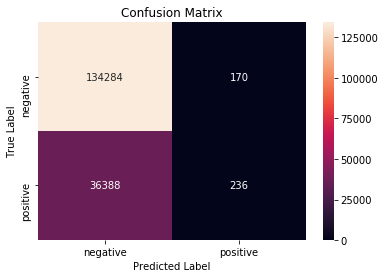

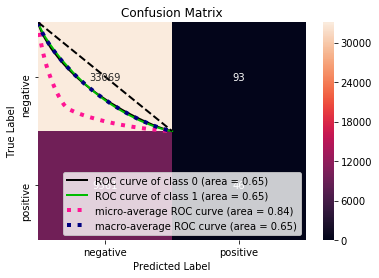


Time taken to run this cell : 2:47:09.026019


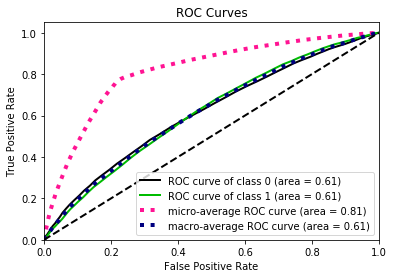

In [925]:
start = datetime.datetime.now()
print("Start Time =",start)
roc_score_train = []
roc_score_cv = []

# instantiate learning model (k = 171)
knn = KNeighborsClassifier(n_neighbors=171,algorithm='brute')
   
# fitting the model 
knn.fit(X_train_std, y_train)

#ROC score of Train Data
train_pred = []    #to get confusion matrix
for m in range(0,len(X_train_std),1000):
    train_pred.extend(knn.predict(X_train_std[m:m+1000]))
    
train_prob = []
for m in range(0,len(X_train_std),1000):
    train_prob.extend(knn.predict_proba(X_train_std[m:m+1000]))

train_prob2 = np.asarray(train_prob)
train_prob3 = train_prob2[:,1]
scores_train = roc_auc_score(y_train,train_prob3)
roc_score_train.append(scores_train)
    

#ROC score of CV Data
cv_pred = []    #to get confusion matrix
for m in range(0,len(X_cv_std),1000):
    cv_pred.extend(knn.predict(X_cv_std[m:m+1000]))

cv_prob = []
for n in range(0,len(X_cv_std),1000):
    cv_prob.extend(knn.predict_proba(X_cv_std[n:n+1000]))

cv_prob2 = np.asarray(cv_prob)
cv_prob3 = cv_prob2[:,1]
scores_cv = roc_auc_score(y_cv,cv_prob3)
roc_score_cv.append(scores_cv)       

print("For Hyperparameter value of K = ",i)
print("AUC Score on Train Data: ",roc_score_train[-1])
print("AUC Score on CV Data: ",roc_score_cv[-1])

plot_confusion_matrix(y_train, train_pred)
plot_ROC_curve(y_train,train_prob)

plot_confusion_matrix(y_cv, cv_pred)
plot_ROC_curve(y_cv,cv_prob)

#ROC score of Test Data
test_prob = []   #to get ROC curve
for m in range(0,len(X_test_std),1000):
    test_prob.extend(knn.predict_proba(X_test_std[m:m+1000]))
    
test_pred = []    #to get confusion matrix
for m in range(0,len(X_test_std),1000):
    test_pred.extend(knn.predict(X_test_std[m:m+1000]))

print("\nTime taken to run this cell :", datetime.datetime.now() - start)

In [927]:
# test_pred_unbal_data = []    
# for m in range(0,len(X_test),1000):
#     test_pred_unbal_data.extend(knn.predict(X_test[m:m+1000]))
    
test_pred_unbal_data_2= []
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_data_2,"test_pred.pkl")

print(np.shape(test_pred_unbal_data_2))
print(type(test_pred_unbal_data_2))
print(type(test_df))

test_pred_unbal_data_2_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_data_2_df.loc[:, 'loan_default'] = test_pred_unbal_data

# checking for unique values
val = unique_value(test_pred_unbal_data_2_df['loan_default'])

test_pred_unbal_data_2_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_data_2_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_data_2_df[:10]

(0,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
0    109033
1      3359
Name: loan_default, dtype: int64


,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,0
4,708663,0
5,725530,0
6,708592,0
7,714975,0
8,712795,0
9,708656,0


## 2.2 Naive Bayes 

In [928]:
# Normalizing data as Naive Bayes doesn't work for negative values
from sklearn.preprocessing import MinMaxScaler
std_scal_minmax = MinMaxScaler(feature_range=(0, 1))
std_scal_minmax.fit(X_train)
X_train_minmax_std = std_scal_minmax.transform(X_train)
X_test_minmax_std = std_scal_minmax.transform(X_test)

In [930]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
start = datetime.datetime.now()
print("Start Time =",start)

#Applying Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_minmax_std, y_train_1)

# evaluating Grid Search
alphas = np.array([1,0.1,0.01,0, 10, 100])
scorers = {'recall_score': make_scorer(roc_auc_score)}
grid = GridSearchCV(estimator=clf,
                  param_grid=dict(alpha=alphas),
                  scoring= scorers  , cv=3, refit='recall_score', return_train_score=True)
grid.fit(X_train_minmax_std, y_train_1)
print(grid)
results = grid.cv_results_

# summarize the results of the grid search
print("\nBest score: ",grid.best_score_)
NB_OPTIMAL_clf = grid.best_estimator_
best_alpha_bow = grid.best_estimator_.alpha
print("Optimal value of Hyperparameter: ",best_alpha_bow)

print("\nTime taken to run this cell :", datetime.datetime.now() - start)

Start Time = 2019-04-20 19:12:52.608544
GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': array([1.e+00, 1.e-01, 1.e-02, 0.e+00, 1.e+01, 1.e+02])},
       pre_dispatch='2*n_jobs', refit='recall_score',
       return_train_score=True,
       scoring={'recall_score': make_scorer(roc_auc_score)}, verbose=0)

Best score:  0.5
Optimal value of Hyperparameter:  1.0

Time taken to run this cell : 0:00:14.659446


In [931]:
#Applying Multinomial Naive Bayes
clf = MultinomialNB(alpha=1)
clf.fit(X_train_minmax_std, y_train_1)

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

In [938]:
start = datetime.datetime.now()
print("Start Time =",start)

test_pred_unbal_Naive = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_Naive.extend(clf.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_Naive,"test_pred_unbal_Naive.pkl")

print(np.shape(test_pred_unbal_Naive))
print(type(test_pred_unbal_Naive))
print(type(test_df))

test_pred_unbal_Naive_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_Naive_df.loc[:, 'loan_default'] = test_pred_unbal_Naive

# checking for unique values
val = unique_value(test_pred_unbal_Naive_df['loan_default'])

test_pred_unbal_Naive_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_Naive_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_Naive_df[:10]

print("\nTime taken to run this cell :", datetime.datetime.now() - start)

Start Time = 2019-04-20 19:33:27.050691
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
1    69446
0    42946
Name: loan_default, dtype: int64

Time taken to run this cell : 0:00:25.517503


## 2.3 Logistic Regression (penalty=l1) 

Start Time = 2019-04-20 20:58:45.373920
LogisticRegression(C=1, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l1', random_state=None,
          solver='warn', tol=0.0001, verbose=0, warm_start=False)

Best score:  0.6312096563191422

Scores for alphas:
{'mean_fit_time': array([102.94772013, 499.74478134, 705.02560981]), 'std_fit_time': array([  4.38862352,  35.2512651 , 174.95855201]), 'mean_score_time': array([0.11599986, 0.08428955, 0.09299588]), 'std_score_time': array([0.01555517, 0.00478342, 0.01018879]), 'param_C': masked_array(data=[0.01, 1, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01}, {'C': 1}, {'C': 100}], 'split0_test_score': array([0.62388534, 0.62508684, 0.62511285]), 'split1_test_score': array([0.63701921, 0.63921059, 0.6391976 ]), 'split2_test_score': array([0.62609945, 0.62933154, 0.6293079

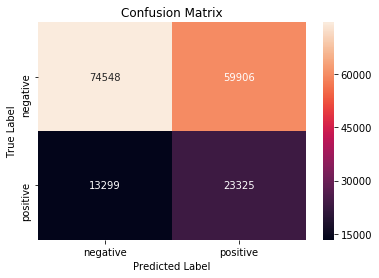

Start Time = 2019-04-20 22:27:33.313215
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
1    94561
0    17831
Name: loan_default, dtype: int64

Time taken to run this cell : 1:29:15.606089


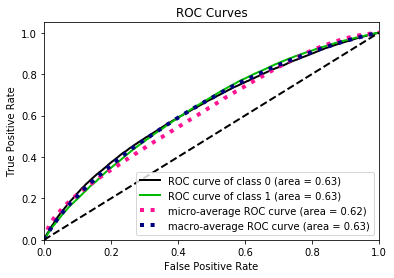

In [940]:
from sklearn.linear_model import LogisticRegression
start = datetime.datetime.now()
print("Start Time =",start)

#Using GridSearchCV with L1 Regularizer
tuned_parameters = [{'C': [ 10**-2, 10**0, 10**2]}]
model_l1 = GridSearchCV(LogisticRegression(penalty='l1',class_weight='balanced'), tuned_parameters, scoring = 'roc_auc', cv=3)
model_l1.fit(X_train_std, y_train)

GS_OPTIMAL_clf_l1 = model_l1.best_estimator_
print(GS_OPTIMAL_clf_l1)
best_score_model_l1 = model_l1.best_score_
print("\nBest score: ",best_score_model_l1)

print("\nScores for alphas:")
print(model_l1.cv_results_)
print("\nBest estimator:")
print(model_l1.best_estimator_)
print("\nBest score:")
print(model_l1.best_score_)
print("\nBest parameters:")
print(model_l1.best_params_)

best_model = LogisticRegression(penalty='l1',class_weight='balanced',C=model_l1.best_params_['C'])
best_model.fit(X_train_std, y_train)

train_pred = best_model.predict(X_train_std)          #to get confusion matrix
train_prob = best_model.predict_proba(X_train_std)    #to get ROC curve

plot_confusion_matrix(y_train, train_pred)
plot_ROC_curve(y_train,train_prob)

start1 = datetime.datetime.now()
print("Start Time =",start1)

#Predicting test classes
test_pred_unbal_log = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_log.extend(best_model.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_log,"test_pred_unbal_log.pkl")

print(np.shape(test_pred_unbal_log))
print(type(test_pred_unbal_log))
print(type(test_df))

test_pred_unbal_log_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_log_df.loc[:, 'loan_default'] = test_pred_unbal_log

# checking for unique values
val = unique_value(test_pred_unbal_log_df['loan_default'])

test_pred_unbal_log_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_log_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_log_df[:10]

print("\nTime taken to run this cell :", datetime.datetime.now() - start)

## 2.4 Logistic Regression (penalty='l2') 

Start Time = 2019-04-20 22:30:40.505390
LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

Best score:  0.631054482832767

Scores for alphas:
{'mean_fit_time': array([ 3.969829  , 19.41575694, 13.56571372]), 'std_fit_time': array([0.32364968, 8.99612728, 2.15061718]), 'mean_score_time': array([0.08099302, 0.08099508, 0.07900079]), 'std_score_time': array([0.00164086, 0.00081465, 0.00163268]), 'param_C': masked_array(data=[0.01, 1, 100],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'C': 0.01}, {'C': 1}, {'C': 100}], 'split0_test_score': array([0.62273572, 0.6246633 , 0.62467143]), 'split1_test_score': array([0.63627436, 0.63932977, 0.63938148]), 'split2_test_score': array([0.62566776, 0.62896408, 0.62911054]), 'mean_tes

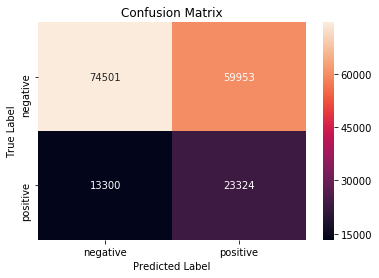

Start Time = 2019-04-20 22:33:58.536330
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
1    94619
0    17773
Name: loan_default, dtype: int64

Time taken to run this cell : 0:03:45.162550


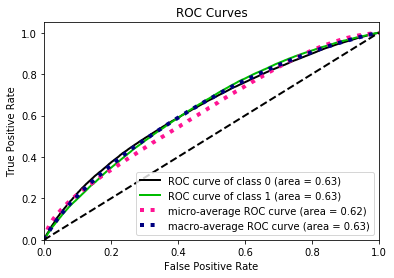

In [941]:
from sklearn.linear_model import LogisticRegression
start = datetime.datetime.now()
print("Start Time =",start)

#Using GridSearchCV with L1 Regularizer
tuned_parameters = [{'C': [ 10**-2, 10**0, 10**2]}]
model_l2 = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=3)
model_l2.fit(X_train_std, y_train)

GS_OPTIMAL_clf_l2 = model_l2.best_estimator_
print(GS_OPTIMAL_clf_l2)
best_score_model_l2 = model_l2.best_score_
print("\nBest score: ",best_score_model_l2)

print("\nScores for alphas:")
print(model_l2.cv_results_)
print("\nBest estimator:")
print(model_l2.best_estimator_)
print("\nBest score:")
print(model_l2.best_score_)
print("\nBest parameters:")
print(model_l2.best_params_)

best_model_l2 = LogisticRegression(penalty='l2',class_weight='balanced',C=model_l2.best_params_['C'],)
best_model_l2.fit(X_train_std, y_train)

train_pred = best_model_l2.predict(X_train_std)          #to get confusion matrix
train_prob = best_model_l2.predict_proba(X_train_std)    #to get ROC curve

plot_confusion_matrix(y_train, train_pred)
plot_ROC_curve(y_train,train_prob)

start1 = datetime.datetime.now()
print("Start Time =",start1)

#Predicting test classes
test_pred_unbal_log2 = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_log2.extend(best_model_l2.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_log2,"test_pred_unbal_log2.pkl")

print(np.shape(test_pred_unbal_log2))
print(type(test_pred_unbal_log2))
print(type(test_df))

test_pred_unbal_log2_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_log2_df.loc[:, 'loan_default'] = test_pred_unbal_log2

# checking for unique values
val = unique_value(test_pred_unbal_log2_df['loan_default'])

test_pred_unbal_log2_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_log2_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_log2_df[:10]


print("\nTime taken to run this cell :", datetime.datetime.now() - start)

## Decision Trees

Start Time = 2019-04-21 14:24:48.902041
GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': (10, 50, 100, 500), 'min_samples_split': (5, 10, 50, 100)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best score:  0.6146842057862447

Optimal value of Hyperparameter, max_depth :  10

Optimal value of Hyperparameter, min_samples_split :  100


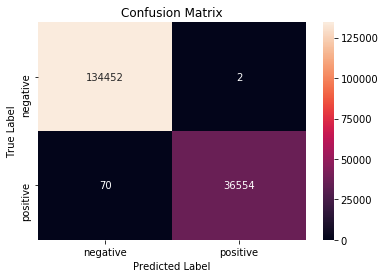

Start Time = 2019-04-21 14:31:56.170669
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
0    66164
1    46228
Name: loan_default, dtype: int64

Time taken to run this cell : 0:07:33.607718


In [945]:
from sklearn import tree
start = datetime.datetime.now()
print("Start Time =",start)

clf_dtree = tree.DecisionTreeClassifier()
clf_dtree = clf_dtree.fit(X_train_std,y_train)

parameter = {
            'max_depth': (10, 50, 100, 500),
            'min_samples_split': (5, 10, 50, 100)
            }
gsearch_dt = GridSearchCV(estimator = clf_dtree,
                            param_grid= parameter,
                            cv=3,
                            scoring='roc_auc')
gsearch_dt.fit(X_train_std,y_train)
print(gsearch_dt)

results = gsearch_dt.cv_results_

# summarize the results of the grid search
print("\nBest score: ",gsearch_dt.best_score_)
NB_OPTIMAL_clf = gsearch_dt.best_estimator_

best_max_depth = gsearch_dt.best_estimator_.max_depth
print("\nOptimal value of Hyperparameter, max_depth : ",best_max_depth)

best_min_samples_split = gsearch_dt.best_estimator_.min_samples_split
print("\nOptimal value of Hyperparameter, min_samples_split : ",best_min_samples_split)

# With Best parameters
clf_dtree_best = tree.DecisionTreeClassifier(max_depth=best_max_depth, min_samples_split=best_min_samples_split)
clf_dtree_best = clf_dtree.fit(X_train_std,y_train)
      
    
train_pred = clf_dtree_best.predict(X_train_std)          #to get confusion matrix
#train_prob = clf_dtree_best.predict_proba(X_train_std)    #to get ROC curve

plot_confusion_matrix(y_train, train_pred)
#plot_ROC_curve(y_train,train_prob)

start1 = datetime.datetime.now()
print("Start Time =",start1)

#Predicting test classes
test_pred_unbal_dtree = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_dtree.extend(clf_dtree_best.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_dtree,"test_pred_unbal_dtree.pkl")

print(np.shape(test_pred_unbal_dtree))
print(type(test_pred_unbal_dtree))
print(type(test_df))

test_pred_unbal_dtree_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_dtree_df.loc[:, 'loan_default'] = test_pred_unbal_dtree

# checking for unique values
val = unique_value(test_pred_unbal_dtree_df['loan_default'])

test_pred_unbal_dtree_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_dtree_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_dtree_df[:10]

    
print("\nTime taken to run this cell :", datetime.datetime.now() - start)

## Random Forest

Start Time = 2019-04-21 14:32:22.654622
GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': (100, 500, 1000), 'min_samples_split': (100, 300, 500)},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

Best score:  0.6324235998919254

Optimal value of Hyperparameter, max_depth :  100

Optimal value of Hyperparameter, min_samples_split :  100


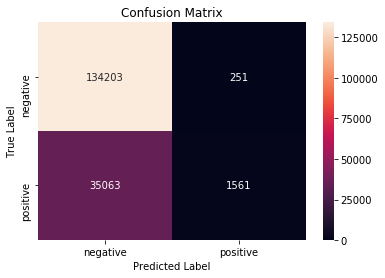

Start Time = 2019-04-21 14:37:39.892452
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
0    89862
1    22530
Name: loan_default, dtype: int64

Time taken to run this cell : 0:05:42.995547


In [946]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

start = datetime.datetime.now()
print("Start Time =",start)

clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_std,y_train)

parameter = {
            'max_depth': (100, 500, 1000),
            'min_samples_split': (100, 300, 500)
            }
gsearch_rf = GridSearchCV(estimator = clf_rf,
                            param_grid= parameter,
                            cv=3,
                            scoring='roc_auc')
gsearch_rf.fit(X_train_std,y_train)
print(gsearch_rf)

results = gsearch_rf.cv_results_

# summarize the results of the grid search
print("\nBest score: ",gsearch_rf.best_score_)
NB_OPTIMAL_clf = gsearch_rf.best_estimator_

best_max_depth_bow = gsearch_rf.best_estimator_.max_depth
print("\nOptimal value of Hyperparameter, max_depth : ",best_max_depth_bow)

best_min_samples_split = gsearch_dt.best_estimator_.min_samples_split
print("\nOptimal value of Hyperparameter, min_samples_split : ",best_min_samples_split)

clf_rf = RandomForestClassifier(max_depth=best_max_depth_bow, min_samples_split=best_min_samples_split)
clf_rf.fit(X_train_std,y_train)

train_pred = clf_rf.predict(X_train_std)          #to get confusion matrix
#train_prob = clf_dtree_best.predict_proba(X_train_std)    #to get ROC curve

plot_confusion_matrix(y_train, train_pred)
#plot_ROC_curve(y_train,train_prob)

start1 = datetime.datetime.now()
print("Start Time =",start1)

#Predicting test classes
test_pred_unbal_rf = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_rf.extend(clf_rf.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_rf,"test_pred_unbal_rf.pkl")

print(np.shape(test_pred_unbal_rf))
print(type(test_pred_unbal_rf))
print(type(test_df))

test_pred_unbal_rf_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_rf_df.loc[:, 'loan_default'] = test_pred_unbal_rf

# checking for unique values
val = unique_value(test_pred_unbal_rf_df['loan_default'])

test_pred_unbal_rf_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_rf_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_rf_df[:10]

      
print("\nTime taken to run this cell :", datetime.datetime.now() - start)

## XGBoost

Start Time = 2019-04-21 14:55:44.749465
train_results =  [0.5022381002191652]


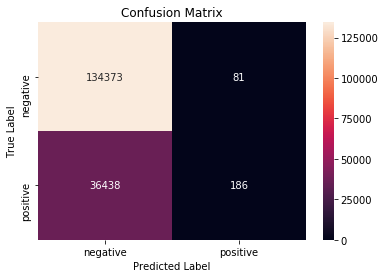

Start Time = 2019-04-21 14:56:47.343946
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 1
0    112392
Name: loan_default, dtype: int64

Time taken to run this cell : 0:01:30.893214


In [947]:
import xgboost as xgb
from sklearn.metrics import roc_curve, auc
train_results = []
start = datetime.datetime.now()
print("Start Time =",start)

xgb_model = xgb.XGBClassifier()
xgb_model.fit(X_train_std, y_train)

train_pred = xgb_model.predict(X_train_std)
train_pred_proba = xgb_model.predict_proba(X_train_std)
    
false_positive_rate, true_positive_rate, thresholds =    roc_curve(y_train, train_pred)
roc_auc_train = auc(false_positive_rate, true_positive_rate)
train_results.append(roc_auc_train)
print("train_results = ", train_results)

train_pred = xgb_model.predict(X_train_std)          #to get confusion matrix
#train_prob = clf_dtree_best.predict_proba(X_train_std)    #to get ROC curve

plot_confusion_matrix(y_train, train_pred)
#plot_ROC_curve(y_train,train_prob)

start1 = datetime.datetime.now()
print("Start Time =",start1)

#Predicting test classes
test_pred_unbal_xgb = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_xgb.extend(xgb_model.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_xgb,"test_pred_unbal_xgb.pkl")

print(np.shape(test_pred_unbal_xgb))
print(type(test_pred_unbal_xgb))
print(type(test_df))

test_pred_unbal_xgb_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_xgb_df.loc[:, 'loan_default'] = test_pred_unbal_xgb

# checking for unique values
val = unique_value(test_pred_unbal_xgb_df['loan_default'])

test_pred_unbal_xgb_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_xgb_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_xgb_df[:10]


print("\nTime taken to run this cell :", datetime.datetime.now() - start)

## 2.5 Linear SVM with penalty= 'l1' 

Start Time = 2019-04-20 22:39:35.598630
Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:   21.6s finished


Best HyperParameter:  {'alpha': 0.001}
Best Accuracy: 60.87%


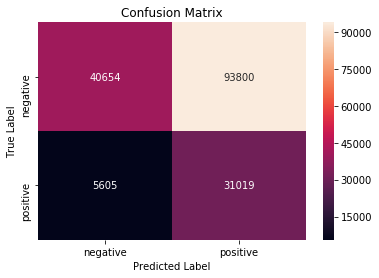

Start Time = 2019-04-20 22:40:04.497383
(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
1    97464
0    14928
Name: loan_default, dtype: int64

Time taken to run this cell : 0:00:55.853386


In [943]:
#from sklearn.svm import SVC
from sklearn import svm
from sklearn.linear_model import SGDClassifier

start = datetime.datetime.now()
print("Start Time =",start)

lin_svc_l1 = SGDClassifier(penalty='l1')
lin_svc_l1.fit(X_train_std, y_train)

param_grid = {'alpha':[0.001, 0.01, 1, 10, 100]}      #params we need to try on classifier
gsv_l1 = GridSearchCV(lin_svc_l1,param_grid,cv=3,verbose=1,scoring='roc_auc')
gsv_l1.fit(X_train_std,y_train)

print("Best HyperParameter: ",gsv_l1.best_params_)
print("Best Accuracy: %.2f%%"%(gsv_l1.best_score_*100))


best_model_l1 = SGDClassifier(penalty='l1',class_weight='balanced',alpha=gsv_l1.best_params_['alpha'])
best_model_l1.fit(X_train_std, y_train)

train_pred = best_model_l1.predict(X_train_std)          #to get confusion matrix
#train_prob = best_model_l1.predict_proba(X_train_std)    #to get ROC curve

plot_confusion_matrix(y_train, train_pred)
#plot_ROC_curve(y_train,train_prob)

start1 = datetime.datetime.now()
print("Start Time =",start1)

#Predicting test classes
test_pred_unbal_svm = []    
for m in range(0,len(X_test),1000):
    test_pred_unbal_svm.extend(best_model_l1.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_unbal_svm,"test_pred_unbal_svm.pkl")

print(np.shape(test_pred_unbal_svm))
print(type(test_pred_unbal_svm))
print(type(test_df))

test_pred_unbal_svm_df = pd.DataFrame(data=test_df['UniqueID'])
test_pred_unbal_svm_df.loc[:, 'loan_default'] = test_pred_unbal_svm

# checking for unique values
val = unique_value(test_pred_unbal_svm_df['loan_default'])

test_pred_unbal_svm_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_unbal_svm_df.csv", index=False, encoding='utf8',mode='a')
test_pred_unbal_svm_df[:10]

print("\nTime taken to run this cell :", datetime.datetime.now() - start)

## Models with equal number of both polarities

In [663]:
# To take equal data for both classes

#Checking for NaN values 
NaN_val = NaN_values(train_df_new_3['loan_default'])

# checking for unique values
val = unique_value(train_df_new_3['loan_default'])

Number of rows with NaN values =  0
Number of unique_values : 2
0    167616
1     46231
Name: loan_default, dtype: int64


In [690]:
# Bifurcating positive and negative data
positive_df = pd.DataFrame()
negative_df = pd.DataFrame()
print(type(positive_df))
print(type(negative_df))

cond = train_df_new_3.loan_default == 1
rows = train_df_new_3.loc[cond, :]
positive_df = positive_df.append(rows, ignore_index=True)

cond = train_df_new_3.loan_default == 0
rows = train_df_new_3.loc[cond, :]
negative_df = negative_df.append(rows, ignore_index=True)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [818]:
positive_df[:10]

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,537409,47145,65550,73.23,67,22807,45,1502,34,0,...,0,0,1991,0,0,1,23,23,0,1
1,624493,57513,66113,88.48,67,22807,45,1501,26,0,...,0,0,31,0,0,0,8,15,1,1
2,539055,52378,60300,88.39,67,22807,45,1495,42,0,...,0,0,0,0,0,0,0,0,1,1
3,548567,53278,61230,89.83,67,22807,45,1493,40,0,...,0,0,2270,0,0,0,7,7,0,1
4,478647,53278,61330,89.68,67,22807,45,1497,45,1,...,0,0,3300,0,0,0,15,33,0,1
5,479533,49478,57010,89.46,67,22807,45,1497,35,1,...,0,0,23309,0,1,0,12,25,4,1
6,483869,49278,57080,89.35,67,22807,45,1495,46,0,...,0,0,3514,0,0,0,47,86,0,1
7,600655,47549,61400,79.80,67,22807,45,1440,25,1,...,0,0,7900,0,1,0,1,1,0,1
8,492995,70017,86760,82.99,67,22807,45,1479,31,0,...,0,0,0,0,0,0,21,21,0,1
9,568857,58259,68500,86.13,67,22807,45,1468,39,0,...,0,0,0,0,0,0,11,11,1,1


In [819]:
frame_1 = pd.DataFrame()
frame_2 = pd.DataFrame()

frame_1 = positive_df.iloc[0:1]
frame_1.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg.csv", index=False, encoding='utf8',mode='a')
frame_2 = negative_df.iloc[0:1] 
frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg.csv", index=False, encoding='utf8',mode='a', header=False)

for loop8 in range(1,46231):
    frame_1 = positive_df.iloc[loop8:loop8+1]
    frame_1.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg.csv", index=False, encoding='utf8',mode='a', header=False)

    frame_2 = negative_df.iloc[loop8:loop8+1] 
    frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg.csv", index=False, encoding='utf8',mode='a', header=False)


In [820]:
#reading data
pos_neg_df = pd.read_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg.csv")

In [821]:
pos_neg_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,537409,47145,65550,73.23,67,22807,45,1502,34,0,...,0,0,1991,0,0,1,23,23,0,1
1,420825,50578,58400,89.55,67,22807,45,1441,35,1,...,0,0,0,0,0,0,0,0,0,0
2,624493,57513,66113,88.48,67,22807,45,1501,26,0,...,0,0,31,0,0,0,8,15,1,1
3,417566,53278,61360,89.63,67,22807,45,1497,34,0,...,0,0,0,0,0,0,0,0,0,0
4,539055,52378,60300,88.39,67,22807,45,1495,42,0,...,0,0,0,0,0,0,0,0,1,1


In [822]:
"""
removing following columns:
branch_id
supplier_id
manufacturer_id
Current_pincode_ID
Employee_code_ID
MobileNo_Avl_Flag
PERFORM_CNS.SCORE.DESCRIPTION
DisbursalDate
"""
X_train = pos_neg_df.iloc[:, [1,2,3,8,9,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]].values
y_train = pos_neg_df.iloc[:, 40].values

X_test = test_df_new_3.iloc[:, [1,2,3,8,9,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]].values

print(np.shape(X_train))
print(np.shape(y_train))
print(type(X_train))
print(type(y_train))

print(np.shape(X_test))
print(type(X_test))

(92462, 32)
(92462,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(103077, 32)
<class 'numpy.ndarray'>


In [823]:
#Taking Train and CV data from Train data
# 92462 * 8 = 73969.6    -->     [80:20] ratio

X_train_8 = X_train[0:73970]
X_cv_2 = X_train[73970:]

y_train_8 = y_train[0:73970]
y_cv_2 = y_train[73970:]

print(np.shape(X_train_8))
print(np.shape(X_cv_2))
print(np.shape(y_train_8))
print(np.shape(y_cv_2))

(73970, 32)
(18492, 32)
(73970,)
(18492,)


### Standardization of Data 

In [824]:
std_scal = StandardScaler(with_mean=False)
std_scal.fit(X_train)
X_train_std = std_scal.transform(X_train)
X_test_std = std_scal.transform(X_test)

std_scal.fit(X_train_8)
X_train_8_std = std_scal.transform(X_train_8)
X_cv_2_std = std_scal.transform(X_cv_2)

### Normalization of Data 

In [610]:
# Normalizing data as Naive Bayes doesn't work for negative values
from sklearn.preprocessing import MinMaxScaler
std_scal_minmax = MinMaxScaler(feature_range=(0, 1))
std_scal_minmax.fit(X_train)
X_train_minmax_std = std_scal_minmax.transform(X_train)
X_test_minmax_std = std_scal_minmax.transform(X_test)

# 2. Models

## 2.1 KNN

In [825]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score
startTime1 = datetime.datetime.now()

roc_score_train = []
roc_score_cv = []

for i in range(1,100,4):
    startTime = datetime.datetime.now()
    print("Current Time = ",startTime)

# instantiate learning model 
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
   
    # fitting the model 
    knn.fit(X_train_8_std, y_train_8)
    
    #ROC score of Train Data
    train_prob = []
    for m in range(0,len(X_train_8_std),1000):
        train_prob.extend(knn.predict_proba(X_train_8_std[m:m+1000]))
     
    train_prob2 = np.asarray(train_prob)
    train_prob3 = train_prob2[:,1]
    scores_train = roc_auc_score(y_train_8,train_prob3)
    roc_score_train.append(scores_train)
    
    #ROC score of CV Data
    cv_prob = []
    for n in range(0,len(X_cv_2_std),1000):
        cv_prob.extend(knn.predict_proba(X_cv_2_std[n:n+1000]))

    cv_prob2 = np.asarray(cv_prob)
    cv_prob3 = cv_prob2[:,1]
    scores_cv = roc_auc_score(y_cv_2,cv_prob3)
    roc_score_cv.append(scores_cv)       
       
    print("For Hyperparameter value of K = ",i)
    print("AUC Score on Train Data: ",roc_score_train[-1])
    print("AUC Score on CV Data: ",roc_score_cv[-1])
    print("Time taken for this loop {}".format(datetime.datetime.now() - startTime))
    print("**************\n")
    
print("Time taken for this cell {}".format(datetime.datetime.now() - startTime1))

Current Time =  2019-04-17 23:59:23.748968
For Hyperparameter value of K =  1
AUC Score on Train Data:  0.9999324050290658
AUC Score on CV Data:  0.7587605451005841
Time taken for this loop 0:07:56.311666
**************

Current Time =  2019-04-18 00:07:20.072633
For Hyperparameter value of K =  5
AUC Score on Train Data:  0.8441859543224677
AUC Score on CV Data:  0.93803609247352
Time taken for this loop 0:09:35.578149
**************

Current Time =  2019-04-18 00:16:55.659781
For Hyperparameter value of K =  9
AUC Score on Train Data:  0.810200302440205
AUC Score on CV Data:  0.95711563176509
Time taken for this loop 0:09:37.682882
**************

Current Time =  2019-04-18 00:26:33.353664
For Hyperparameter value of K =  13
AUC Score on Train Data:  0.7940991646460519
AUC Score on CV Data:  0.9620326840157104
Time taken for this loop 0:09:38.183711
**************

Current Time =  2019-04-18 00:36:11.547377
For Hyperparameter value of K =  17
AUC Score on Train Data:  0.7830691998694

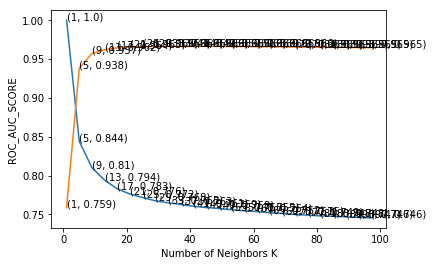

In [827]:
# creating odd list of K for KNN
myList = list(range(1,100,4))
neighbors = myList
#neighbors = list(filter(lambda x: x % 4 != 0, myList))

plt.plot(neighbors, roc_score_train)
plt.plot(neighbors, roc_score_cv)

for xy in zip(neighbors, np.round(roc_score_train,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
for xy in zip(neighbors, np.round(roc_score_cv,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('ROC_AUC_SCORE')
plt.show()

## Equal data of both classes arranged together in random order

In [835]:
# sampling equal number of negative class as is positive class
frame_2 = pd.DataFrame()
frame_2 = negative_df.iloc[0:1] 
frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/neg_class.csv", index=False, encoding='utf8',mode='a')

for loop12 in range(1,46231):
    frame_2 = negative_df.iloc[loop12:loop12+1] 
    frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/neg_class.csv", index=False, encoding='utf8',mode='a', header=False)


In [836]:
#reading data
neg_class_df = pd.read_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/neg_class.csv")
neg_class_df.head()

,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,420825,50578,58400,89.55,67,22807,45,1441,35,1,...,0,0,0,0,0,0,0,0,0,0
1,417566,53278,61360,89.63,67,22807,45,1497,34,0,...,0,0,0,0,0,0,0,0,0,0
2,518279,54513,61900,89.66,67,22807,45,1501,29,0,...,0,0,1347,0,0,0,21,24,0,0
3,529269,46349,61500,76.42,67,22807,45,1502,31,1,...,0,0,0,0,0,0,0,0,0,0
4,510278,43894,61900,71.89,67,22807,45,1501,30,1,...,0,0,0,0,0,0,2,2,0,0


In [847]:
# taking equal random positive and negative data
frame_1 = pd.DataFrame()
frame_2 = pd.DataFrame()

frame_1 = positive_df.iloc[0:1]
frame_1.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv", index=False, encoding='utf8',mode='a')
frame_2 = neg_class_df.iloc[0:1] 
frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv", index=False, encoding='utf8',mode='a', header=False)

tot_index_pos = 0
tot_index_neg = 0
loop9 = 1
while(tot_index_pos <= 46231 or tot_index_neg <= 46231):
    if(tot_index_pos <= 46231):
        pos_index = random.randint(1,10)
        if(pos_index <= (46231-tot_index_pos)):
            for loop10 in range(0,pos_index):
                frame_1 = positive_df.iloc[loop9+loop10:loop9+loop10+1]
                frame_1.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv", index=False, encoding='utf8',mode='a', header=False)
            tot_index_pos = tot_index_pos + pos_index
        else: 
            new_pos_index = 46231-tot_index_pos
            for loop12 in range(0,new_pos_index):
                frame_1 = positive_df.iloc[loop9+loop12:loop9+loop12+1]
                frame_1.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv", index=False, encoding='utf8',mode='a', header=False)
            tot_index_pos = tot_index_pos + pos_index
    else:
        pass
    
    if(tot_index_neg <= 46231):
        neg_index = random.randint(1,10)
        if(neg_index <= (46231-tot_index_neg)):
            for loop11 in range(0,neg_index):
                frame_2 = negative_df.iloc[loop9+loop11:loop9+loop11+1] 
                frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv", index=False, encoding='utf8',mode='a', header=False)
            tot_index_neg = tot_index_neg + neg_index
        else:
            new_neg_index = 46231-tot_index_neg
            for loop13 in range(0,neg_index):
                frame_2 = negative_df.iloc[loop9+loop13:loop9+loop13+1] 
                frame_2.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv", index=False, encoding='utf8',mode='a', header=False)
            tot_index_neg = tot_index_neg + neg_index
    else:
        pass
    
    loop9+=1

In [849]:
#reading data
pos_neg_rand_df = pd.read_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/pos_neg_rand.csv")
print(np.shape(pos_neg_rand_df))

# checking for unique values
val = unique_value(pos_neg_rand_df['loan_default'])

pos_neg_rand_df.head()

(92474, 41)
Number of unique_values : 2
0    46242
1    46232
Name: loan_default, dtype: int64


,UniqueID,disbursed_amount,asset_cost,ltv,branch_id,supplier_id,manufacturer_id,Current_pincode_ID,Date.of.Birth,Employment.Type,...,SEC.SANCTIONED.AMOUNT,SEC.DISBURSED.AMOUNT,PRIMARY.INSTAL.AMT,SEC.INSTAL.AMT,NEW.ACCTS.IN.LAST.SIX.MONTHS,DELINQUENT.ACCTS.IN.LAST.SIX.MONTHS,AVERAGE.ACCT.AGE,CREDIT.HISTORY.LENGTH,NO.OF_INQUIRIES,loan_default
0,537409,47145,65550,73.23,67,22807,45,1502,34,0,...,0,0,1991,0,0,1,23,23,0,1
1,420825,50578,58400,89.55,67,22807,45,1441,35,1,...,0,0,0,0,0,0,0,0,0,0
2,624493,57513,66113,88.48,67,22807,45,1501,26,0,...,0,0,31,0,0,0,8,15,1,1
3,539055,52378,60300,88.39,67,22807,45,1495,42,0,...,0,0,0,0,0,0,0,0,1,1
4,548567,53278,61230,89.83,67,22807,45,1493,40,0,...,0,0,2270,0,0,0,7,7,0,1


In [850]:
"""
removing following columns:
branch_id
supplier_id
manufacturer_id
Current_pincode_ID
Employee_code_ID
MobileNo_Avl_Flag
PERFORM_CNS.SCORE.DESCRIPTION
DisbursalDate
"""
X_train_random = pos_neg_rand_df.iloc[:, [1,2,3,8,9,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]].values
y_train_random = pos_neg_rand_df.iloc[:, 40].values

X_test = test_df_new_3.iloc[:, [1,2,3,8,9,11,12,14,15,16,17,18,19,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39]].values

print(np.shape(X_train_random))
print(np.shape(y_train_random))
print(type(X_train_random))
print(type(y_train_random))

print(np.shape(X_test))
print(type(X_test))

(92474, 32)
(92474,)
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(103077, 32)
<class 'numpy.ndarray'>


In [851]:
#Taking Train and CV data from Train data
# 92462 * 8 = 73969.6    -->     [80:20] ratio

X_train_8_random = X_train_random[0:73970]
X_cv_2_random = X_train_random[73970:]

y_train_8_random = y_train_random[0:73970]
y_cv_2_random = y_train_random[73970:]

print(np.shape(X_train_8_random))
print(np.shape(X_cv_2_random))
print(np.shape(y_train_8_random))
print(np.shape(y_cv_2_random))

(73970, 32)
(18504, 32)
(73970,)
(18504,)


### Standardization of Data

In [854]:
std_scal_random = StandardScaler(with_mean=False)
std_scal_random.fit(X_train_8_random)
X_train_8_random_std = std_scal_random._randomtransform(X_train_8_random)
X_cv_2_random_std = std_scal_random.transform(X_cv_2_random)

## KNN

In [856]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import precision_score, recall_score,roc_auc_score
startTime1 = datetime.datetime.now()

roc_score_train = []
roc_score_cv = []

for i in range(1,100,4):
    startTime = datetime.datetime.now()
    print("Current Time = ",startTime)

# instantiate learning model 
    knn = KNeighborsClassifier(n_neighbors=i,algorithm='brute')
   
    # fitting the model 
    knn.fit(X_train_8_random_std, y_train_8_random)
    
    #ROC score of Train Data
    train_prob = []
    for m in range(0,len(X_train_8_random_std),1000):
        train_prob.extend(knn.predict_proba(X_train_8_random_std[m:m+1000]))
     
    train_prob2 = np.asarray(train_prob)
    train_prob3 = train_prob2[:,1]
    scores_train = roc_auc_score(y_train_8_random,train_prob3)
    roc_score_train.append(scores_train)
    
    #ROC score of CV Data
    cv_prob = []
    for n in range(0,len(X_cv_2_random_std),1000):
        cv_prob.extend(knn.predict_proba(X_cv_2_random_std[n:n+1000]))

    cv_prob2 = np.asarray(cv_prob)
    cv_prob3 = cv_prob2[:,1]
    scores_cv = roc_auc_score(y_cv_2_random,cv_prob3)
    roc_score_cv.append(scores_cv)       
       
    print("For Hyperparameter value of K = ",i)
    print("AUC Score on Train Data: ",roc_score_train[-1])
    print("AUC Score on CV Data: ",roc_score_cv[-1])
    print("Difference in ROC score of Train & CV data = ", (roc_score_train[-1] - roc_score_cv[-1]))
    print("Time taken for this loop {}".format(datetime.datetime.now() - startTime))
    print("**************\n")
    
print("Time taken for this cell {}".format(datetime.datetime.now() - startTime1))

Current Time =  2019-04-18 12:38:12.331052
For Hyperparameter value of K =  1
AUC Score on Train Data:  0.9999187564317824
AUC Score on CV Data:  0.5439915888945819
Difference in ROC score of Train & CV data =  0.45592716753720053
Time taken for this loop 0:08:54.989459
**************

Current Time =  2019-04-18 12:47:07.331509
For Hyperparameter value of K =  5
AUC Score on Train Data:  0.9999796562104852
AUC Score on CV Data:  0.5465703837757278
Difference in ROC score of Train & CV data =  0.4534092724347575
Time taken for this loop 0:11:46.979563
**************

Current Time =  2019-04-18 12:58:54.322072
For Hyperparameter value of K =  9
AUC Score on Train Data:  0.9890109966589457
AUC Score on CV Data:  0.5580670285490081
Difference in ROC score of Train & CV data =  0.4309439681099375
Time taken for this loop 0:10:44.014326
**************

Current Time =  2019-04-18 13:09:38.345398
For Hyperparameter value of K =  13
AUC Score on Train Data:  0.9219412049511023
AUC Score on CV D

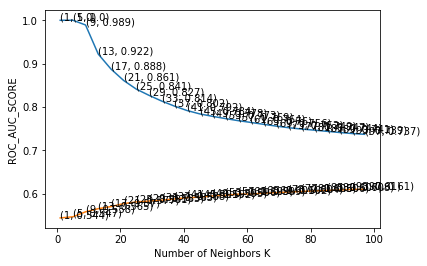

In [864]:
# creating odd list of K for KNN
myList = list(range(1,100,4))
neighbors = myList
#neighbors = list(filter(lambda x: x % 4 != 0, myList))

plt.plot(neighbors, roc_score_train)
plt.plot(neighbors, roc_score_cv)

for xy in zip(neighbors, np.round(roc_score_train,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')
for xy in zip(neighbors, np.round(roc_score_cv,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('ROC_AUC_SCORE')
plt.show()

In [902]:
test_pred_bal_data = []    
for m in range(0,len(X_test),1000):
    test_pred_bal_data.extend(knn.predict(X_test[m:m+1000]))
    
import joblib                                                #  * DO NOT RUN *
joblib.dump(test_pred_bal_data,"test_pred_bal.pkl")

['test_pred_bal.pkl']

In [904]:
print(np.shape(test_pred_bal_data))
print(type(test_pred_bal_data))
print(type(test_df_new_3))

test_pred_bal_data_df = pd.DataFrame(data=test_df['UniqueID'])
#test_pred_bal_data_df = pd.DataFrame(columns=['UniqueID','loan_default'], fill='1')
test_pred_bal_data_df.loc[:, 'loan_default'] = test_pred_bal_data

test_pred_bal_data[:10]
# checking for unique values
val = unique_value(test_pred_bal_data_df['loan_default'])

(112392,)
<class 'list'>
<class 'pandas.core.frame.DataFrame'>
Number of unique_values : 2
0    90244
1    22148
Name: loan_default, dtype: int64


In [906]:
test_pred_bal_data_df.to_csv("D:/Data Science/DataSets/Hackathon/ltfs-datascience-finhack-an-online-hackathon/test_pred_bal_data_df.csv", index=False, encoding='utf8',mode='a')
test_pred_bal_data_df[:10]

,UniqueID,loan_default
0,655269,0
1,723482,0
2,758529,0
3,763449,1
4,708663,0
5,725530,0
6,708592,1
7,714975,0
8,712795,0
9,708656,0


# Models with unbalanced Dataset

In [5]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Models/Paramters","Train AUC Score", "CV AUC Score"]

x.add_row(["KNN : ",0.6531705023820983, 0.6138066414780946])
x.add_row(["Naive Bayes : ", 0.5, '-'])
x.add_row(["Logistic Regression (l1): ",0.6312096563191422, '-'])
x.add_row(["Logistic Regression (l2): ", 0.631054482832767, '-'])
x.add_row(["Decision Trees: ",0.6146842057862447, '-'])
x.add_row(["Random Forest: ", 0.6324235998919254, '-'])

x.add_row(["XGBOOST: ", 0.5022381002191652, '-'])
x.add_row(["Linear SVM (l1): ", 0.6087, '-'])
x.add_row(["Random Forest: ", 0.6324235998919254, '-'])


print(x)

+----------------------------+--------------------+--------------------+
|      Models/Paramters      |  Train AUC Score   |    CV AUC Score    |
+----------------------------+--------------------+--------------------+
|           KNN :            | 0.6531705023820983 | 0.6138066414780946 |
|       Naive Bayes :        |        0.5         |         -          |
| Logistic Regression (l1):  | 0.6312096563191422 |         -          |
| Logistic Regression (l2):  | 0.631054482832767  |         -          |
|      Decision Trees:       | 0.6146842057862447 |         -          |
|      Random Forest:        | 0.6324235998919254 |         -          |
|         XGBOOST:           | 0.5022381002191652 |         -          |
|     Linear SVM (l1):       |       0.6087       |         -          |
|      Random Forest:        | 0.6324235998919254 |         -          |
+----------------------------+--------------------+--------------------+
